In [59]:
import os
import sys , time

from tqdm import tqdm
import warnings , ipdb
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

#plt.style.use('ggplot')

In [10]:
warnings.filterwarnings('ignore')

In [11]:
def tsplot(y, lags=None, figsize=(12, 16), style='ggplot'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [12]:
# fb_df = (pd.read_csv('/home/vlad/data/AMZN_und.csv',parse_dates=['last'])
#          .drop_duplicates()
#         .set_index('last'))

# fb_df.head()

In [13]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

/home/vlad/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


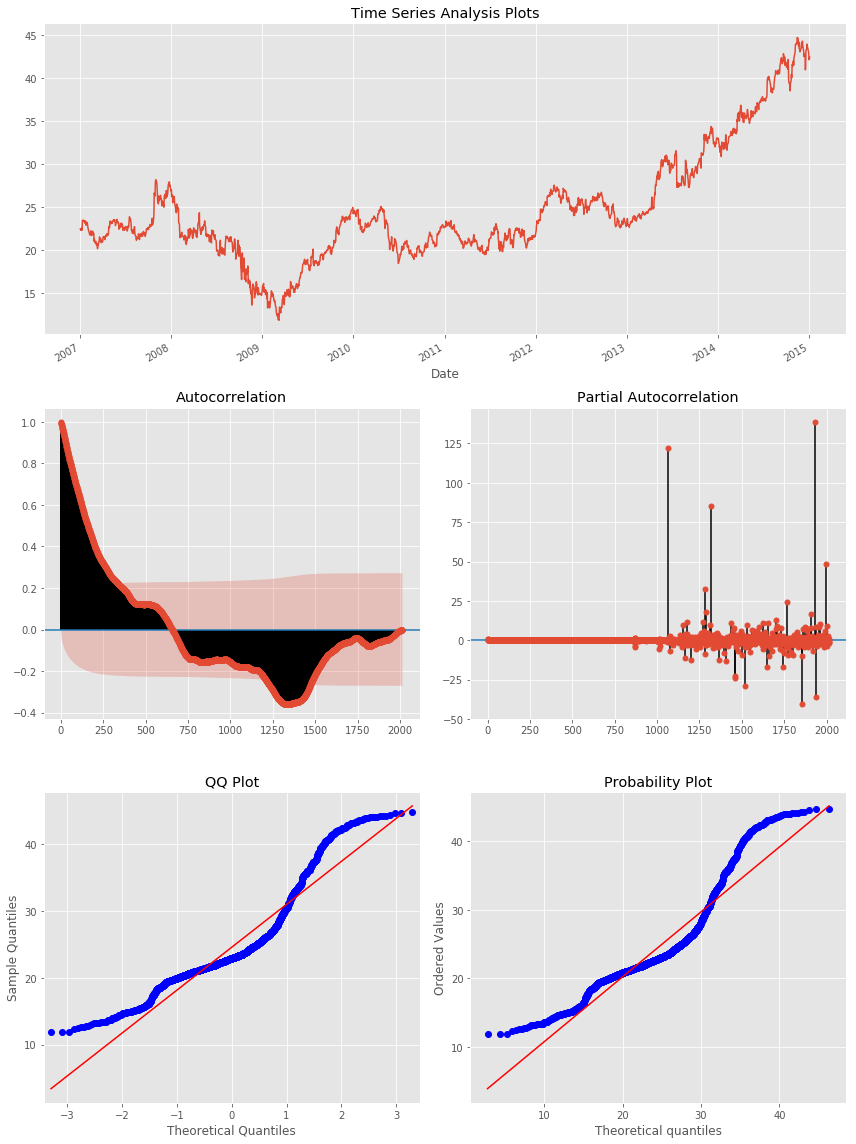

In [35]:
#TS plot 
tsplot(data.MSFT)

In [20]:
#TS plot diff
# tsplot(data.MSFT.shift(1))

/home/vlad/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


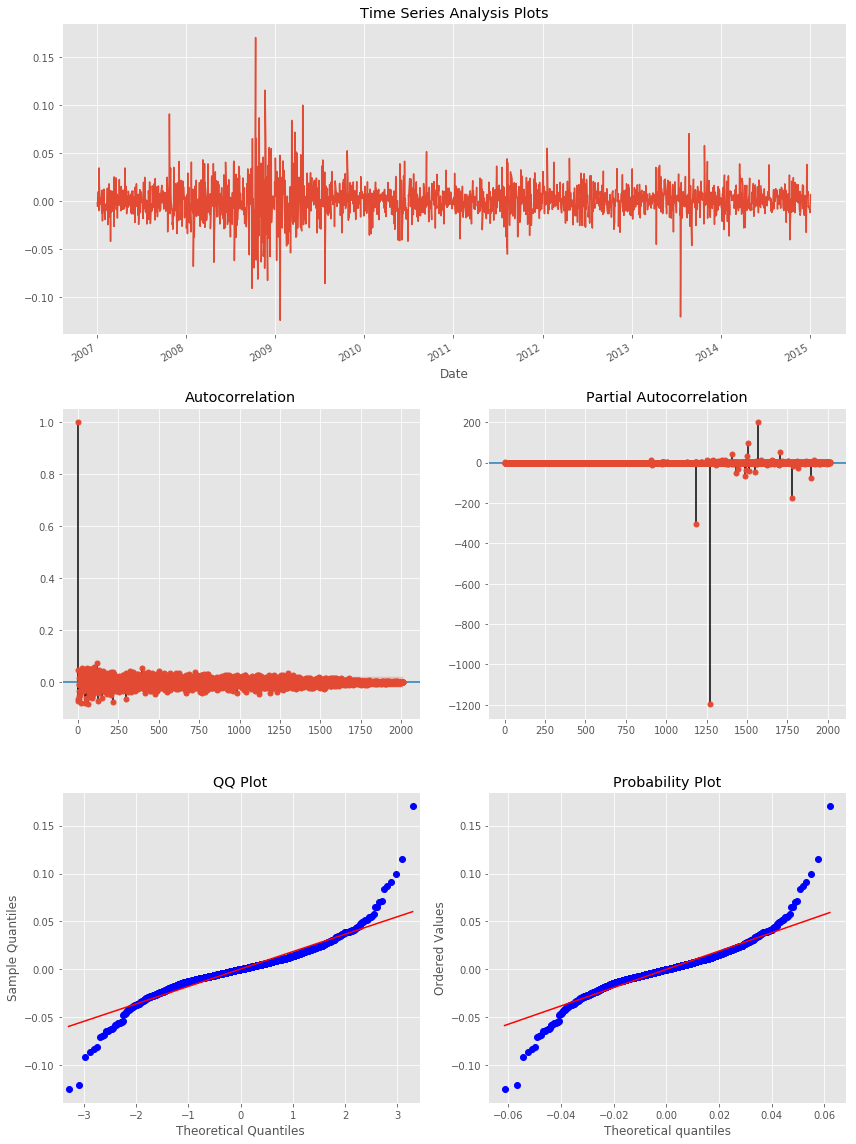

In [33]:
tsplot(lrets.MSFT)

In [21]:
# _ = tsplot(res_tup[2].resid**2, lags=30)
#Squared residuals show autocorrelation. Let's fit a GARCH model and see how it does. 

In [22]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = res_tup[1][0]
o_ = res_tup[1][1]
q_ = res_tup[1][2]

# Using student T distribution usually provides better fit
am = arch_model(res_tup[2].resid, p=p_, o=o_, q=q_, dist='StudentsT')
garch_model_res = am.fit(update_freq=5, disp='off')
print(garch_model_res.summary())

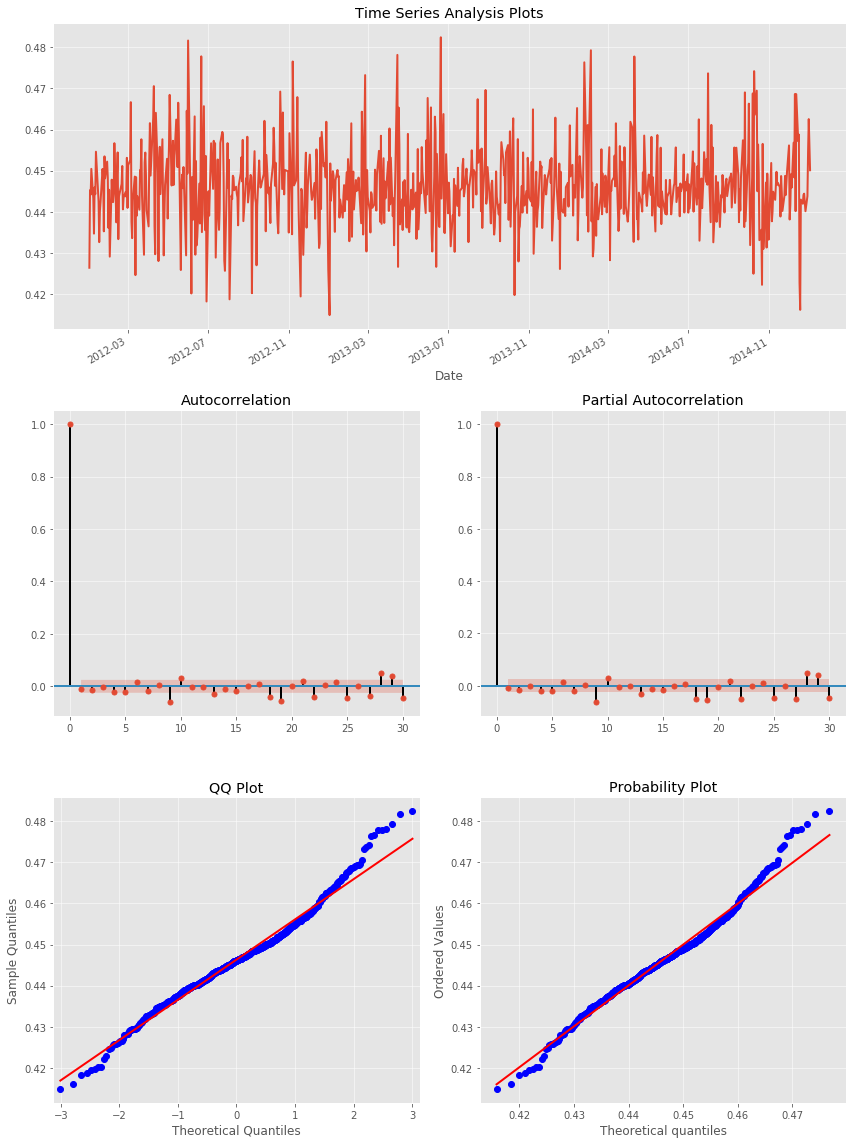

In [65]:
_ = tsplot(garch_model_res.resid**2, lags=30)

In [64]:
#Create backtester

# Find Arima model

def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except Exception as e:
                    #print(e)
                    continue
    #print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl


def backtest(lTS=None):
    windowLength = 2010#252
    foreLength = len(lTS) - windowLength
    signal = 0*lTS[-foreLength:]
    print('Running backtesting ...')
    time.sleep(1)
    for d in tqdm(range(foreLength)):

        # create a rolling window by selecting 
        # values between d+1 and d+T of S&P500 returns
        
        TS = lTS[(1+d):(windowLength+d)] 

        # Find the best ARIMA fit 
        # set d = 0 since we've already taken log return of the series
        res_tup = _get_best_model(TS)
        order = res_tup[1]
        model = res_tup[2]
        #ipdb.set_trace()
        if order is not None:
            #now that we have our ARIMA fit, we feed this to GARCH model
            p_ = order[0]
            o_ = order[1]
            q_ = order[2]

            am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
            res = am.fit(update_freq=5, disp='off')

            # Generate a forecast of next day return using our fitted model
            out = res.forecast(horizon=1, start=None, align='origin')

            #Set trading signal equal to the sign of forecasted return
            # Buy if we expect positive returns, sell if negative

            signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])
        else:
            signal.iloc[d] = np.nan
    return signal

In [65]:
signal = backtest()

Running backtesting ...











  0%|          | 0/4 [00:00<?, ?it/s]








 25%|██▌       | 1/4 [00:56<02:49, 56.39s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)









 50%|█████     | 2/4 [01:53<01:53, 56.66s/it]








 75%|███████▌  | 3/4 [02:49<00:56, 56.52s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)









100%|██████████| 4/4 [04:01<00:00, 61.16s/it]










In [66]:
signal

SPY  TLT  MSFT
Date                      
2014-12-29  1.0  1.0   1.0
2014-12-30 -1.0 -1.0  -1.0
2014-12-31  1.0  1.0   1.0
2015-01-02  1.0  1.0   1.0